# KittiInstanceSeg2015: Cut out cars

In [1]:
from IPython.display import display

from tools import image_utils

DATASET = "../../dataset"
EXAMPLE_FRAME = "000045_10"  # contains 2 cars
semantic_label_car = 26  # car

In [2]:
import os
from typing import Any, List, Tuple, Optional, Callable

import numpy as np
import torchvision.datasets.utils as vision_utils
from PIL import Image
from torch.utils.data.dataset import Dataset


class KittiInstanceSeg2015(Dataset):
    """`KITTI <http://www.cvlibs.net/datasets/kitti/eval_instance_seg.php?benchmark=instanceSeg2015>`_ Dataset.
    Args:
        root (string): Root directory where images are downloaded to.
            Expects the following folder structure if download=False:
            .. code::
                <root>
                    └── KittiInstanceSeg2015
                        ├── data_semantics.zip
                        ├── training
                        |   ├── image_2
                        |   └── instance
                        |   └── semantic
                        |   └── semantic_rgb
                        └── testing
                            └── image_2
        train (bool, optional): Use ``train`` split if true, else ``test`` split.
            Defaults to ``train``.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        target_label (str, optional): Choose one of target labels ``instance``, ``semantic``, or ``semantic_rgb``
            Defaults to ``instance``.

    """

    data_url = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip"
    image_dir_name = "image_2"
    instance_dir_name = "instance"
    semantic_dir_name = "semantic"
    semantic_rgb_dir_name = "semantic_rgb"
    target_labels = [instance_dir_name, semantic_dir_name, semantic_rgb_dir_name]

    def __init__(
            self,
            root: str,
            target_label: str = 'instance',
            train: bool = True,
            download: bool = False,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            target_filter: List[int] = None
    ):
        self.images = []
        self.targets = []
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.target_filter = target_filter
        self._location = "training" if self.train else "testing"
        if target_label not in self.target_labels:
            raise RuntimeError("Target label not found. Available labels: instance, semantic, semantic_rgb")
        self._target_label = target_label

        if download:
            self.download()
        if not self._check_exists():
            raise RuntimeError("Dataset not found. You may use download=True to download it.")

        image_dir = os.path.join(self._class_folder, self._location, self.image_dir_name)
        if self.train:
            labels_dir = os.path.join(self._class_folder, self._location, self._target_label)

        for img_file in os.listdir(image_dir):
            self.images.append(os.path.join(image_dir, img_file))
            if self.train:
                self.targets.append(os.path.join(labels_dir, img_file))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """Get item at a given index.

        Args:
            index (int): Index
        Returns:
            tuple: (image, target), where
            image is PIL image
            target is a list of `Instance`s.
        """
        image = Image.open(self.images[index])
        target = None
        if self.train:
            parse_target = getattr(self, f"_parse_{self._target_label}_target")
            target = parse_target(index)

        if self.transform:
            image = self.transform(image)

        return image, target

    def _parse_instance_target(self, index: int) -> List:
        target = []
        image_np = np.asarray(Image.open(self.images[index]))
        mask_np = np.asarray(Image.open(self.targets[index]))

        uniq_instance_ids = np.unique(mask_np)
        for instance_id in uniq_instance_ids:
            if instance_id > 0:
                label = instance_id // 256
                if self.target_filter is None or label in self.target_filter:
                    instance = Instance(mask_np, instance_id, image_np, transforms=self.target_transform)
                    target.append(instance)

        return target

    def _parse_semantic_target(self, index: int) -> List:
        raise RuntimeError("Not implemented")

    def _parse_semantic_rgb_target(self, index: int) -> List:
        raise RuntimeError("Not implemented")

    def __len__(self) -> int:
        return len(self.images)

    @property
    def _class_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__)

    def _check_exists(self) -> bool:
        """Check if the data directory exists."""
        folders = [self.image_dir_name]
        if self.train:
            folders.append(self._target_label)
        return all(os.path.isdir(os.path.join(self._class_folder, self._location, fname)) for fname in folders)

    def download(self) -> None:
        """Download the KITTI data if it doesn't exist already."""

        if self._check_exists():
            return

        os.makedirs(self._class_folder, exist_ok=True)

        # download files
        vision_utils.download_and_extract_archive(
            url=self.data_url,
            download_root=self._class_folder,
        )


# --------------------------------------------------------------------------------
# Imported from https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_semantics.zip
# --------------------------------------------------------------------------------
# Cityscapes labels
from collections import namedtuple

# a label and all meta information
Label = namedtuple('Label', [

    'name',  # The identifier of this label, e.g. 'car', 'person', ... .
    # We use them to uniquely name a class

    'id',  # An integer ID that is associated with this label.
    # The IDs are used to represent the label in ground truth images
    # An ID of -1 means that this label does not have an ID and thus
    # is ignored when creating ground truth images (e.g. license plate).
    # Do not modify these IDs, since exactly these IDs are expected by the
    # evaluation server.

    'trainId',  # Feel free to modify these IDs as suitable for your method. Then create
    # ground truth images with train IDs, using the tools provided in the
    # 'preparation' folder. However, make sure to validate or submit results
    # to our evaluation server using the regular IDs above!
    # For trainIds, multiple labels might have the same ID. Then, these labels
    # are mapped to the same class in the ground truth images. For the inverse
    # mapping, we use the label that is defined first in the list below.
    # For example, mapping all void-type classes to the same ID in training,
    # might make sense for some approaches.
    # Max value is 255!

    'category',  # The name of the category that this label belongs to

    'categoryId',  # The ID of this category. Used to create ground truth images
    # on category level.

    'hasInstances',  # Whether this label distinguishes between single instances or not

    'ignoreInEval',  # Whether pixels having this class as ground truth label are ignored
    # during evaluations or not

    'color',  # The color of this label
])
# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]
# Create dictionaries for a fast lookup
# Please refer to the main method below for example usages!
# name to label object
name2label = {label.name: label for label in labels}
# id to label object
id2label = {label.id: label for label in labels}
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]


# ------------------------------------------------------------------------------------------------

class Instance(object):
    instance_id: int = 0
    label: Label = None
    instance_number: int = 0
    bbox: tuple[int, int, int, int]
    size: tuple[int, int]
    __image: Image = None
    __instance_mask: np.array = None

    def __init__(self, mask_np: np.array, instance_id: int, image_np: np.array = None, extract_inplace: bool = True,
                 clear_background: bool = True,
                 transforms=None):
        if instance_id == -1:
            return
        self.instance_id = int(instance_id)
        self.label = id2label[int(self.instance_id // 256)]
        self.instance_number = int(self.instance_id % 256)
        self.transforms = transforms
        self.__parse_mask(mask_np)

        if extract_inplace:
            if image_np is None:
                raise RuntimeError("Original image 'image_np' should be given to extract the instance from it.")
            self.__image = self.extract_instance(image_np, mask_np, clear_background)

    @property
    def image(self) -> Image:
        if self.__image is None:
            raise RuntimeError(
                "Instance image is not extracted yet. Call instance.`extract` method or "
                "make extract_inplace=True while creating an instance")
        return self.__image

    @property
    def mask(self) -> np.array:
        return self.__instance_mask

    def __parse_mask(self, mask_np):
        segmentation = np.where(mask_np == self.instance_id)
        if segmentation[0].size > 0:
            x_min = int(np.min(segmentation[1]))
            x_max = int(np.max(segmentation[1]))
            y_min = int(np.min(segmentation[0]))
            y_max = int(np.max(segmentation[0]))
            self.bbox = (x_min, y_min, x_max, y_max)
            self.size = (x_max - x_min, y_max - y_min)

    def extract_instance(self, image_np: np.array, mask_np: np.array, clear_background: bool = True) -> Image:
        x_min, y_min, x_max, y_max = self.bbox
        cropped_image = image_np[y_min:y_max, x_min:x_max, :]
        extracted_image = Image.fromarray(cropped_image, mode='RGB')

        self.__instance_mask = self.extract_mask(mask_np)

        if clear_background:
            cropped_mask = mask_np[y_min:y_max, x_min:x_max]
            c = cropped_mask.reshape((cropped_mask.shape[0], cropped_mask.shape[1], 1))
            # mask=black(0), background=white(255)
            # bg_blacked_mask = np.where(c != self.instance_id, image_np * 0, np.ones_like(image_np) * 255)
            bg_blacked_image = np.where(c != self.instance_id, cropped_image * 0, cropped_image)  # 0=black
            extracted_image = self.clear_background(bg_blacked_image)

        if self.transforms:
            extracted_image = self.transforms(extracted_image)

        return extracted_image

    def extract_mask(self, mask_np: np.array) -> np.array:
        bg_blacked_mask = np.where(mask_np != self.instance_id, mask_np * 0, np.ones_like(mask_np) * 255)
        return bg_blacked_mask

    @staticmethod
    def clear_background(image_np: Image, color: tuple[int] = (0, 0, 0)):
        image = Image.fromarray(image_np).copy().convert("RGBA")
        datas = image.getdata()

        cleared_image = []
        for item in datas:
            if item[0] == color[0] and item[1] == color[1] and item[2] == color[2]:
                cleared_image.append((0, 0, 0, 0))
            else:
                cleared_image.append(item)

        image.putdata(cleared_image)
        return image

    def __str__(self):
        return "(" + str(self.instance_id) + ")"

Sample count: 200
Instance count: 33


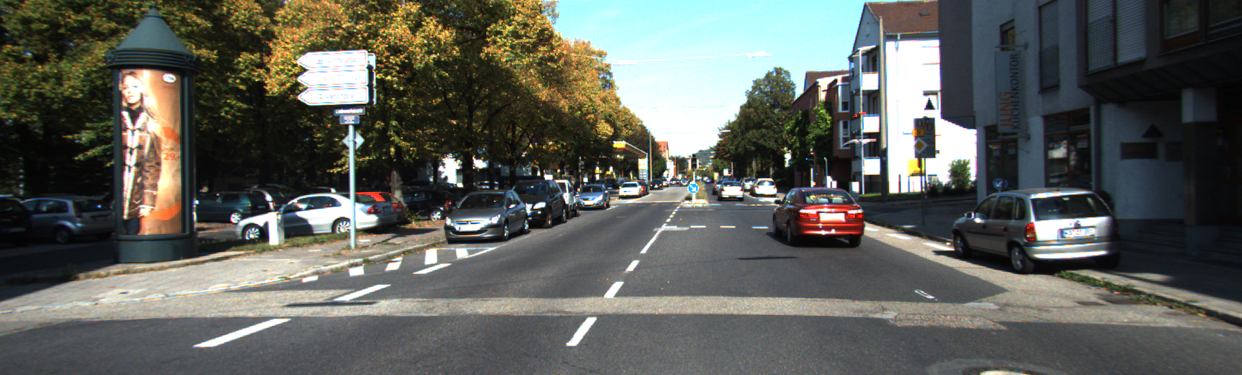

In [4]:
train_dataset = KittiInstanceSeg2015(root=DATASET,
                                     train=True,
                                     download=True,
                                     target_label='instance')
print(f"Sample count: {len(train_dataset)}")
img, trg = train_dataset[0]
print(f"Instance count: {len(trg)}")
img

In [9]:
train_dataset = KittiInstanceSeg2015(root=DATASET,
                                     train=True,
                                     download=True,
                                     target_label='instance',
                                     target_filter=[semantic_label_car],
                                     )
img, trg = train_dataset[0]
print(f"Car instance count: {len(trg)}")
instance_0 = trg[0]
instance_0.image

Car instance count: 21


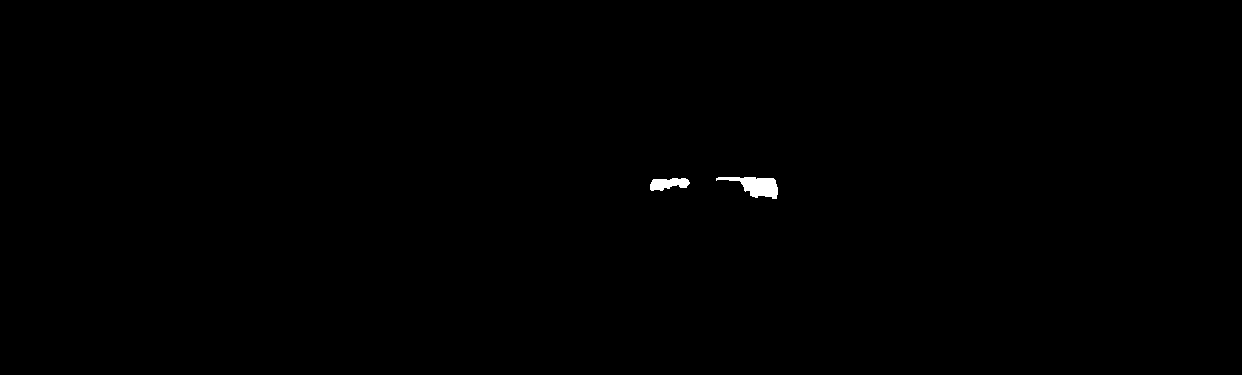

In [27]:
Image.fromarray(instance_0.mask).convert('L')

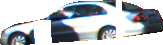

In [22]:
instance_10 = trg[10]
instance_10.image

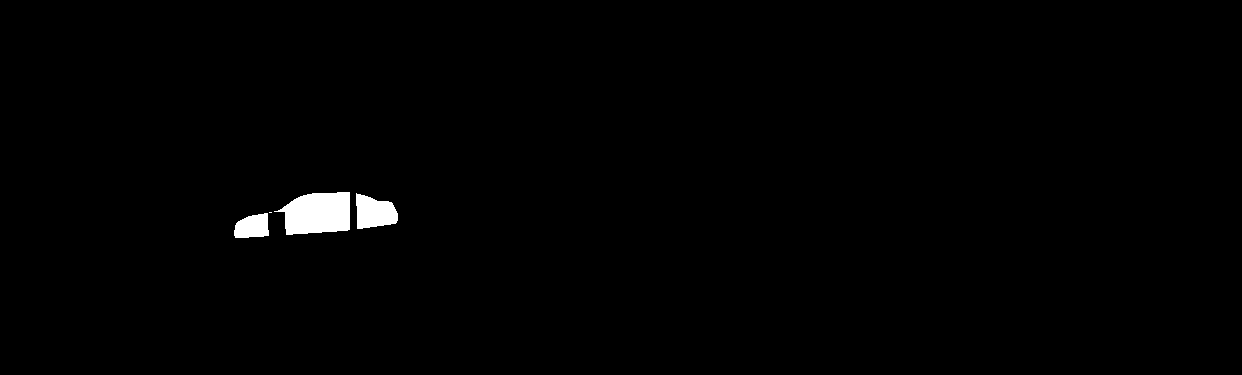

In [28]:
Image.fromarray(instance_10.mask).convert('L')